<a href="https://colab.research.google.com/github/austinbennysmith/CMIP6/blob/main/Averaging_ssp585.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install fsspec
!pip install netCDF4
!apt-get -qq install python-cartopy python3-cartopy;
!pip uninstall -y shapely;
!pip install shapely --no-binary shapely;
!pip install eofs
! pip install --upgrade xarray zarr gcsfs cftime nc-time-axis
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import zarr
import fsspec
import gcsfs
from eofs.xarray import Eof
from nc_time_axis import NetCDFTimeConverter, CalendarDateTime
import cftime
from google.colab import drive
drive.mount('/content/gdrive')
images_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/images'

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = 12, 6

In [2]:
df = pd.read_csv('https://storage.googleapis.com/cmip6/cmip6-zarr-consolidated-stores.csv')
ssp585 = df.query("variable_id == 'pr' & experiment_id == 'ssp585' & table_id == 'Amon'")
ssp585

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (10) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,activity_id,institution_id,source_id,experiment_id,member_id,table_id,variable_id,grid_label,zstore,dcpp_init_year,version
275156,ScenarioMIP,AS-RCEC,TaiESM1,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/AS-RCEC/TaiESM1/ssp585/...,NaN,20200901
275522,ScenarioMIP,AWI,AWI-CM-1-1-MR,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/AWI/AWI-CM-1-1-MR/ssp58...,NaN,20190529
275877,ScenarioMIP,BCC,BCC-CSM2-MR,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/BCC/BCC-CSM2-MR/ssp585/...,NaN,20190314
276318,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585...,NaN,20190708
276364,ScenarioMIP,CAMS,CAMS-CSM1-0,ssp585,r2i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/CAMS/CAMS-CSM1-0/ssp585...,NaN,20190924
...,...,...,...,...,...,...,...,...,...,...,...
350576,ScenarioMIP,NOAA-GFDL,GFDL-ESM4,ssp585,r1i1p1f1,Amon,pr,gr1,gs://cmip6/ScenarioMIP/NOAA-GFDL/GFDL-ESM4/ssp...,NaN,20180701
351061,ScenarioMIP,NUIST,NESM3,ssp585,r1i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/NUIST/NESM3/ssp585/r1i1...,NaN,20190728
351099,ScenarioMIP,NUIST,NESM3,ssp585,r2i1p1f1,Amon,pr,gn,gs://cmip6/ScenarioMIP/NUIST/NESM3/ssp585/r2i1...,NaN,20190731
351171,ScenarioMIP,THU,CIESM,ssp585,r1i1p1f1,Amon,pr,gr,gs://cmip6/ScenarioMIP/THU/CIESM/ssp585/r1i1p1...,NaN,20200605


In [ ]:
all_time_avgs = []
all_maps = []
keyslist = ['DJF', 'MAM', 'JJA', 'SON']

# Useful stackexchange post: https://stackoverflow.com/questions/40272222/select-xarray-pandas-index-based-on-specific-months
def is_djf(month):
  return (month>=12) | ((month>=1) & (month<=2))
def is_mam(month):
  return (month>=3) & (month<=5)
def is_jja(month):
  return (month>=6) & (month<=8)
def is_son(month):
  return (month>=9) & (month<=11)

for z in range(len(ssp585.zstore.values)):
  print(z)
  # Accessing the file, getting it to just the lats and lons I want:
  zstore = ssp585.zstore.values[z]
  mapper = fsspec.get_mapper(zstore)
  ds = xr.open_zarr(mapper, consolidated=True, decode_times=True) # Make decode_times=True to convert dates to datetime objects?? The problem is, Colab doesn't seem to like my installation of nc-time-axis. I could try a Jupyter Binder, or keep Googling to try to solve this.
  pr = ds.pr.sel(lat=slice(11.25,18.75))
  pr = pr.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True)
  lat = ds.lat.sel(lat=slice(11.25,18.75))
  lon = ds.lon.where((ds.lon >= 343.12) | (ds.lon <= 39.38), drop=True) # Not sure exactly what drop means, but I think it doesn't matter

  pr_djf = pr.sel(time=is_djf(pr['time.month']))
  pr_mam = pr.sel(time=is_mam(pr['time.month']))
  pr_jja = pr.sel(time=is_jja(pr['time.month']))
  pr_son = pr.sel(time=is_son(pr['time.month']))


  pr_allseasons = {
      'DJF': pr_djf,
      'MAM': pr_mam,
      'JJA': pr_jja,
      'SON': pr_son
  }
  # Splitting it up by decade:
  decades = np.arange(2010, 2110, 10)
  decade_list = [] # I'll use decade_list for graphing.
  for i in range(len(decades)):
    if i<(len(decades)-1):
      decade_list.append(str(decades[i])+'-'+str(decades[i+1]))
  decade_list[0] = '2015-2020'

  def in_decade(minyear, maxyear, year):
    return (year>=minyear) & (year<maxyear)
  pr_FINAL = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  for j in pr_allseasons.keys():
    for i in range(1, len(decades)):
      pr_FINAL[j].append(pr_allseasons[j].sel(time=in_decade(decades[i-1], decades[i], pr_allseasons[j]['time.year'])))

  time_avg_dict = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  map_dict = {
      'DJF': [],
      'MAM': [],
      'JJA': [],
      'SON': []
  }
  for season in keyslist:
    for i in range(9):
      a = pr_FINAL[season][i].mean(axis=1)
      time_avg_dict[season].append(a.mean(axis=1))
      map_dict[season].append(pr_FINAL[season][i].mean(axis=0))

  all_time_avgs.append(time_avg_dict)
  all_maps.append(map_dict)

In [ ]:
all_concats = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}

for i in range(len(all_time_avgs)):
  for season in keyslist:
    all_concats[season].append(xr.concat([j for j in all_time_avgs[i][season]], 'time'))

# Need to load in the actual values in order to work with numpy arrays:

all_concats_values = {
    'DJF': [],
    'MAM': [],
    'JJA': [],
    'SON': []
}

for season in all_concats_values:
  for i in range(len(all_concats[season])):
    print(i)
    all_concats_values[season].append(all_concats[season][i].values)

In [ ]:
#getting the data into numpy arrays took a while, so I'm saving it as 4 csv files (one for each season)
ssp585_dir = '/content/gdrive/My Drive/EEPS_1430/EEPS 1430 Final Project/ssp585'
for season in keyslist:
  np.savetxt(ssp585_dir+'/'+season+'_ssp585.csv', all_concats_values[season], delimiter=',')

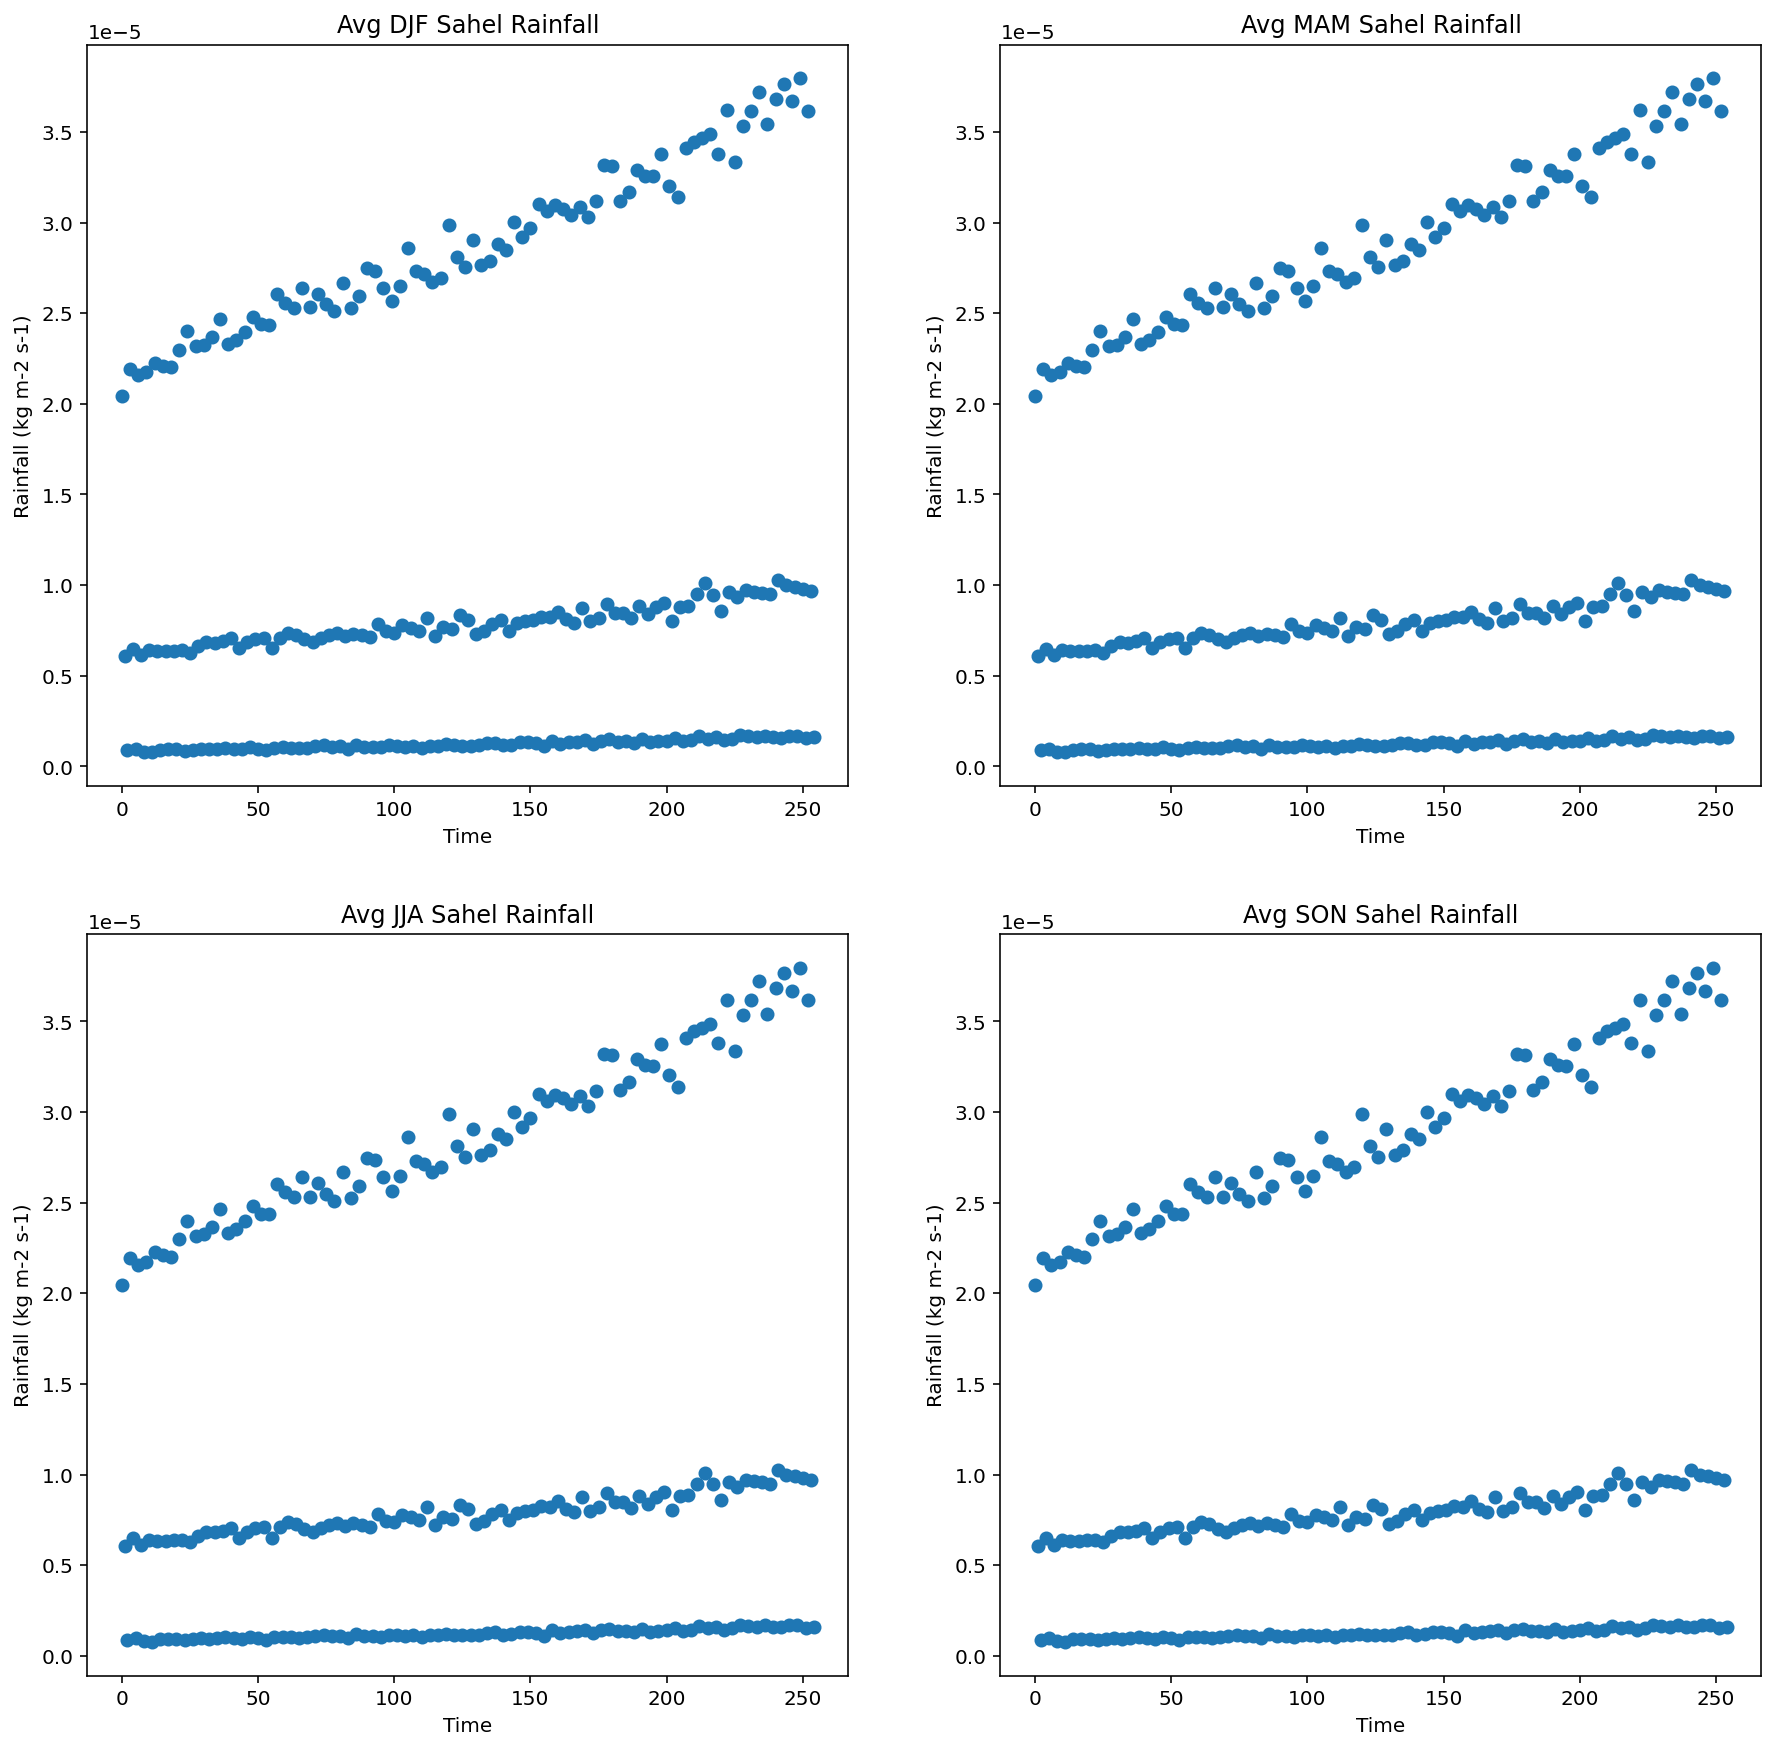

In [6]:
# Reading in the csv files as numpy arrays and plotting averages:
numpy_arrays = {}
for season in keyslist:
  numpy_arrays[season] = np.loadtxt(ssp585_dir+'/'+season+'_ssp585.csv', delimiter=',')
numpy_avgs = {}
for season in keyslist:
  numpy_avgs[season] = numpy_arrays[season].mean(axis=0)
fig2, axarr2 = plt.subplots(nrows=2, ncols=2, figsize=(15, 15))
axlist2 = axarr2.flatten() # Helpful code: https://unidata.github.io/MetPy/latest/examples/Four_Panel_Map.html
for i in range(4):
  axlist2[i].plot(numpy_avgs[season], 'o')
  axlist2[i].set_title("Avg "+keyslist[i]+" Sahel Rainfall")
  axlist2[i].set_xlabel("Time")
  axlist2[i].set_ylabel("Rainfall ("+pr.units+")")
plt.show()